In [62]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
from scipy.signal import savgol_filter
from scipy.stats.stats import pearsonr   
from scipy import interpolate

%matplotlib inline

# Import data

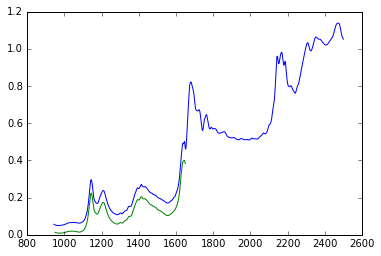

In [63]:
rows=[]
with open('book1.csv','r') as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    for row in reader:
       rows.append([float(x) for x in row]) 
labels = ['64cm-1','32cm-1','16cm-1','8cm-1','4cm-1']

da7250 = []
with open('da7250.csv') as dafile:
    reader = csv.reader(dafile, delimiter=';')
    for row in reader:
        da7250.append([float(x) for x in row])

testRow = rows[2]
testWn = range(-10600,-3999,2)
testWl = [-10000000/x for x in testWn]

targetRow = da7250[0]
targetWl = [x for x in range(950,1651)]

plt.plot(testWl,testRow)
plt.plot(targetWl,targetRow)
plt.show()

# Define DiffSavgolSpectra

In [64]:
def diffSavgolSpectra(s1,s2):
    diff = np.subtract(savgol_filter(s1,11,3,1),savgol_filter(s2,11,3,1))
    return diff
    

# Define Lorentzian filter

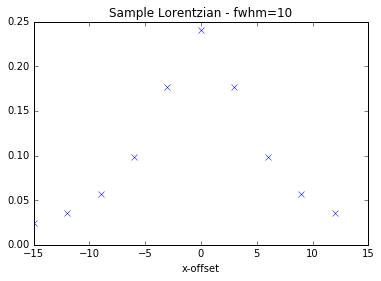

In [65]:

def makeLorentzianFilter(fwhm,xOffsets):
    f = []
    for offset in  xOffsets:
        x= 2* offset / fwhm
        f.append(1.0/(1.0+(x*x)))
    return np.divide(f,np.sum(f))
    
deltaX = np.arange(-15,15,3)

plt.plot(deltaX,makeLorentzianFilter(10,deltaX),"x")
plt.title('Sample Lorentzian - fwhm=10')
plt.ylabel('')
plt.xlabel("x-offset")
plt.show()

# Define Gaussian filter

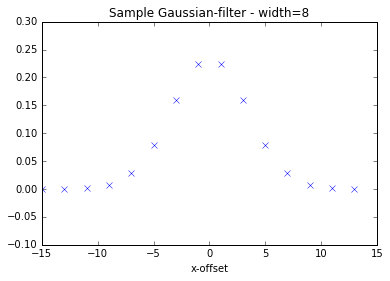

In [66]:
def makeGaussianFilter(fwhm,xOffsets):
    f = []
    c = fwhm / 2.35
    tau = 2 * c**2
    for offset in xOffsets:
        f.append(np.exp (- (offset**2 / tau)))
    return np.divide(f,np.sum(f))
                 
deltaX = np.arange(-15,15,2)
plt.plot(deltaX,makeGaussianFilter(8,deltaX),"x")
plt.title('Sample Gaussian-filter - width=8')
plt.ylabel('')
plt.xlabel("x-offset")
plt.ylim(-0.1,0.3)
plt.show()               

# Define Box filter

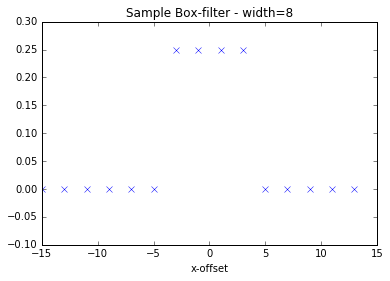

In [69]:
def makeBoxFilter(width,xOffsets):
    f = []
    for offset in xOffsets:
        if abs(offset) < width/2:
            f.append(1)
        else:
            f.append(0)
    return np.divide(f,np.sum(f))

deltaX = np.arange(-15,15,2)
plt.plot(deltaX,makeBoxFilter(8,deltaX),"x")
plt.title('Sample Box-filter - width=8')
plt.ylabel('')
plt.xlabel("x-offset")
plt.ylim(-0.1,0.3)
plt.show()

# Define Triangle filter

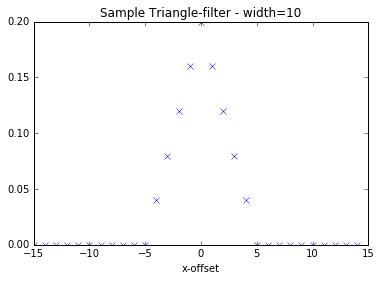

In [70]:
%matplotlib inline
def makeTriangleFilter(width,xOffsets):
    f = []
    for x in xOffsets:
        if abs(x) < width /2 :
            f.append(1- 2 *abs(x/width))
        else:
            f.append(0)
    return np.divide(f,np.sum(f))

xOffsets = np.arange(-15,15,1)
plt.plot(xOffsets,makeTriangleFilter(10,xOffsets),"x")
plt.title('Sample Triangle-filter - width=10')
plt.ylabel('')
plt.xlabel("x-offset")
plt.show()    

# Define apply_filter

In [71]:
def apply_filter(row,rowWl,targetWl,filterWidth,filterFunction):
    result = []
    for twl in targetWl:
        relRowWl = [ twl - x for x in rowWl]
        coeff = filterFunction(filterWidth,relRowWl)
        pointSum = np.sum(np.multiply(coeff,row))
        result.append(pointSum)
    return result
    

# Search best filter widths

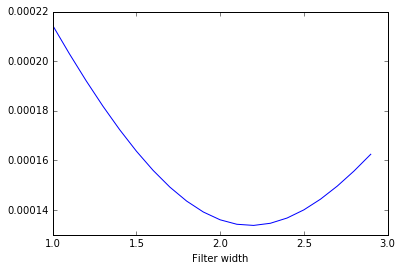

Best Lorentzian width:2.2. Std:0.000133785116561


In [61]:
spectrum_res_16 = rows[2]
spectrum_res_16_egy = [10**x for x in spectrum_res_16]

spectrum_res_64 = rows[0]

std_lorentz = []
std_gaussian = []
std_box = []
std_triangle = []

test_range = np.arange(1,3,0.1)

for filter_width in test_range:

    # filter using Lorentz shape at current filter width
    lorentz_filtered = apply_filter(testRow,testWl,targetWl,filter_width,makeLorentzianFilter)
    diff_lorentz = diffSavgolSpectra(lorentz_filtered,targetRow)
    std_lorentz.append(np.std(diff_lorentz[20:-20]))

    # filter using Gaussian shape at current filter width
#   gaussian_filtered = apply_filter(testRow,testWl,targetWl,filter_width,makeGaussianFilter)
#   diff_gaussian = diffSavgolSpectra(gaussian_filtered,targetRow)
#   std_gaussian.append(np.std(diff_gaussian[20:-20]))

    
    # filter using Box shape at current filter width
#    box_filtered = apply_filter(testRow,testWl,targetWl,filter_width,makeBoxFilter)
#    diff_box = diffSavgolSpectra(box_filtered,targetRow)
#    std_box.append(np.std(diff_box))

    # filter using Triangle shape at current filter width
#    triangle_filtered = apply_filter(testRow,testWl,targetWl,filter_width,makeTriangleFilter)
#    diff_triangle = diffSavgolSpectra(triangle_filtered,targetRow)
#    std_triangle.append(np.std(diff_triangle))
    
plt.plot(test_range,std_lorentz, label='Lorentzian')
#plt.plot(test_range,std_gaussian, label='Gaussian')
#plt.plot(test_range,std_box, label='Box')
#plt.plot(test_range,std_triangle, label='Triangle')
#plt.legend(loc=1)
#plt.title('Net error transforming a 16cm-1 resolution spectrum to 64cm-1')
#plt.ylabel('Std [AU] between transformed and measured.')
plt.xlabel("Filter width")

plt.show()

# Find best
bestLorentzianIdx = np.argmin(std_lorentz)
#bestBoxIdx = np.argmin(std_box)
#bestTriangleIdx = np.argmin(std_triangle)
#bestGaussianIdx = np.argmin(std_gaussian)

# Report best
print ("Best Lorentzian width:" + str(test_range[bestLorentzianIdx]) + ". Std:" + str(std_lorentz[bestLorentzianIdx]))
#print ("Best Box width:" + str(test_range[bestBoxIdx]) + ". Std:" + str(std_box[bestBoxIdx]))
#print ("Best Triangle width:" + str(test_range[bestTriangleIdx]) + ". Std:" + str(std_triangle[bestTriangleIdx]))


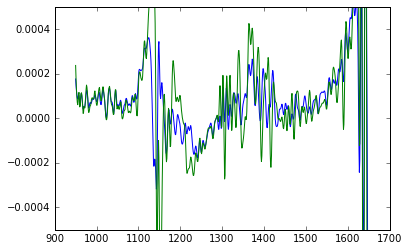

In [27]:
lorentz_filtered1 = apply_filter(testRow,testWl,targetWl,2.2,makeLorentzianFilter)
lorentz_filtered2 = apply_filter(testRow,testWl,targetWl,1,makeLorentzianFilter)
diff_lorentz1 = diffSavgolSpectra(lorentz_filtered1,targetRow)
diff_lorentz2 = diffSavgolSpectra(lorentz_filtered2,targetRow)
plt.plot(targetWl,diff_lorentz1)
plt.plot(targetWl,diff_lorentz2)
plt.ylim(-0.0005,0.0005)
plt.show()